In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
import statsmodels.api as sm

%matplotlib inline

In [2]:
expanded_features = pd.read_pickle("expanded_features.pkl")

853957


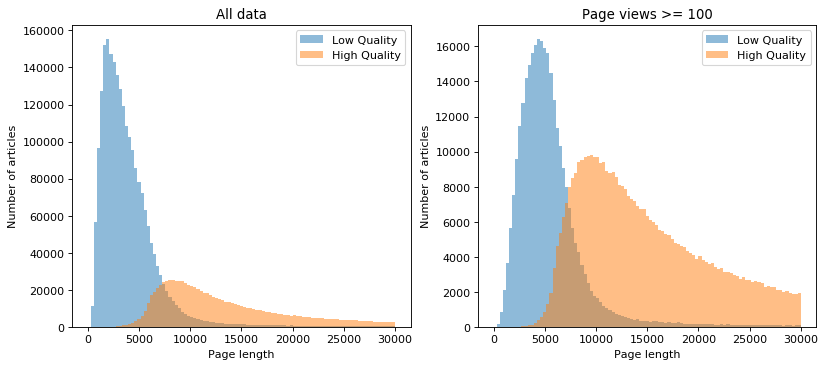

In [3]:
from matplotlib import pyplot
import numpy
import math
from matplotlib.pyplot import figure

figure(num=None, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(121)

bins = numpy.linspace(0, 30000, 100)

pyplot.hist(expanded_features[expanded_features.binary_quality==0].wikicode_len, bins, alpha=0.5, label='Low Quality')
pyplot.hist(expanded_features[expanded_features.binary_quality==1].wikicode_len, bins, alpha=0.5, label='High Quality')
pyplot.legend(loc='upper right')
pyplot.xlabel("Page length")
pyplot.ylabel("Number of articles")
# pyplot.show()
plt.title("All data")


plt.subplot(122)
bins = numpy.linspace(0, 30000, 100)

limited=expanded_features[(expanded_features.pageviews>=100)].copy()

pyplot.hist(limited[limited.binary_quality==0].wikicode_len, bins, alpha=0.5, label='Low Quality')
pyplot.hist(limited[limited.binary_quality==1].wikicode_len, bins, alpha=0.5, label='High Quality')
pyplot.legend(loc='upper right')
pyplot.xlabel("Page length")
pyplot.ylabel("Number of articles")
plt.title("Page views >= 100")

print(len(limited))


853957


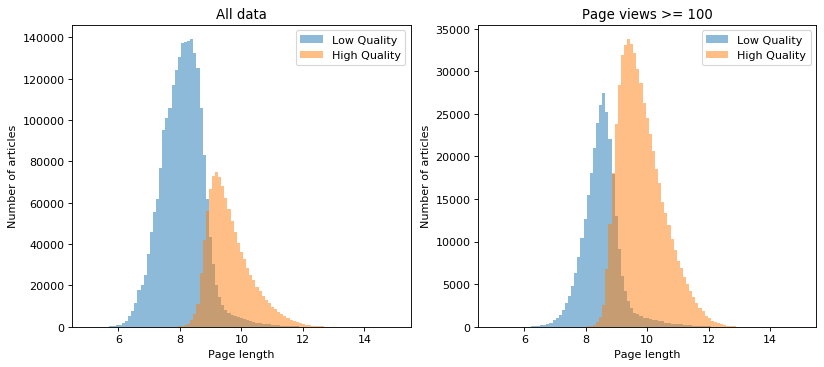

In [4]:
from matplotlib import pyplot
import numpy
import math
from matplotlib.pyplot import figure

figure(num=None, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(121)

bins = numpy.linspace(5, 15, 100)

pyplot.hist(expanded_features[expanded_features.binary_quality==0].wikicode_len_log, bins, alpha=0.5, label='Low Quality')
pyplot.hist(expanded_features[expanded_features.binary_quality==1].wikicode_len_log, bins, alpha=0.5, label='High Quality')
pyplot.legend(loc='upper right')
pyplot.xlabel("Page length")
pyplot.ylabel("Number of articles")
plt.title("All data")


plt.subplot(122)
bins = numpy.linspace(5, 15, 100)

limited=expanded_features[(expanded_features.pageviews>=100)].copy()

pyplot.hist(limited[limited.binary_quality==0].wikicode_len_log, bins, alpha=0.5, label='Low Quality')
pyplot.hist(limited[limited.binary_quality==1].wikicode_len_log, bins, alpha=0.5, label='High Quality')
pyplot.legend(loc='upper right')
pyplot.xlabel("Page length")
pyplot.ylabel("Number of articles")
# pyplot.show()
plt.title("Page views >= 100")

print(len(limited))


In [5]:
valid_features = limited.drop("page_id", axis=1)\
        .drop("title", axis=1)\
        .drop("revision_id", axis=1)\
        .drop("topics", axis=1)\
        .drop("quality", axis=1)\
        .drop("text_length", axis=1)\
        .drop("wikicode_len", axis=1)\
        .drop("pageviews", axis=1)\
        .drop("references_count", axis=1)\
        .drop("page_ct", axis=1)\
        .drop("pageviews_with_clicks", axis=1)
        
valid_features.columns

Index(['Assistance-Article_improvement_and_grading',
       'Assistance-Contents_systems', 'Assistance-Files',
       'Assistance-Maintenance', 'Culture-Arts', 'Culture-Broadcasting',
       'Culture-Crafts_and_hobbies', 'Culture-Entertainment',
       'Culture-Food_and_drink', 'Culture-Internet_culture',
       'Culture-Language_and_literature', 'Culture-Media',
       'Culture-Performing_arts', 'Culture-Philosophy_and_religion',
       'Culture-Plastic_arts', 'Culture-Sports', 'Culture-Visual_arts',
       'Geography-Bodies_of_water', 'Geography-Cities', 'Geography-Countries',
       'Geography-Europe', 'Geography-Landforms', 'Geography-Maps',
       'Geography-Oceania', 'History_And_Society-Business_and_economics',
       'History_And_Society-Education',
       'History_And_Society-History_and_society',
       'History_And_Society-Military_and_warfare',
       'History_And_Society-Politics_and_government',
       'History_And_Society-Transportation', 'STEM-Biology', 'STEM-Chemistry'

Optimization terminated successfully.
         Current function value: 0.436853
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:         binary_quality   No. Observations:               853957
Model:                          Logit   Df Residuals:                   853911
Method:                           MLE   Df Model:                           45
Date:                Thu, 16 Apr 2020   Pseudo R-squ.:                  0.3289
Time:                        11:13:12   Log-Likelihood:            -3.7305e+05
converged:                       True   LL-Null:                   -5.5590e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Assistance-Article_improvement_and_grading

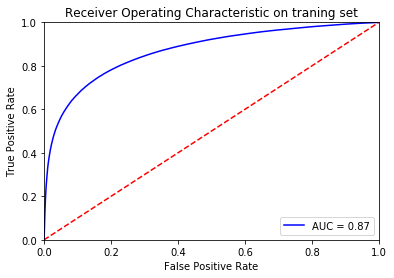

In [6]:
X = valid_features.drop("binary_quality", axis=1)
y = valid_features["binary_quality"]

logit = sm.Logit(y, X)
result = logit.fit()

print(result.summary())

logit = sm.Logit(y, X)
result = logit.fit()

y_pred = result.predict(X)

fpr, tpr, threshold = metrics.roc_curve(y, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic on traning set')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [7]:
limited["probability"] = y_pred

In [8]:
p_bins = {}
for i in range(0, 1000):
    p_bins[i] = []

for index, row in limited.iterrows():
    bin_index = int(row['probability']*1000)
    p_bins[bin_index].append((row['page_id'], 
                              row['probability'], 
                              row['binary_quality'], 
                              row['wikicode_len_log'],
                              row['references_count_log'],
                              row['pageviews_log']
                             ))

In [9]:
import networkx as nx
from networkx.algorithms import bipartite
import builtins
import numpy as np
from scipy.spatial.distance import mahalanobis

def get_matches(samples_bin):
    high_quality = [f for f in samples_bin if f[2]==1]
    low_quality = [f for f in samples_bin if f[2]==0]
    nodes = high_quality+low_quality
    graph_edges = []
    for hq in high_quality:
        for lq in low_quality:
            if builtins.abs(hq[3]-lq[3])<0.1:
                graph_edges.append((hq[0], lq[0], -1*builtins.abs(hq[1]-lq[1])))
    G = nx.Graph()
    G.add_nodes_from([n[0] for n in nodes])
    G.add_weighted_edges_from(graph_edges)
    matched_nodes = nx.algorithms.max_weight_matching(G, maxcardinality=True)
    return [edge for edge in matched_nodes]


In [10]:
from multiprocessing import Pool

p = Pool(30)
matches = p.map(get_matches, [v for k,v in p_bins.items()])

In [11]:
pages = []
for b in matches:
    for m in b:
        pages.append({"page_id": m[0]})
        pages.append({"page_id": m[1]})

matched_pages = pd.DataFrame(pages)
print(len(pages))
matched_pages.head()

197830


,page_id
0,140853
1,2372455
2,2065184
3,8598921
4,182501


In [12]:
matched_features = limited.merge(matched_pages, on="page_id")
len(matched_features)

197830

In [5]:
print(matched_features[(matched_features.binary_quality==0)].page_ct.mean())
print(matched_features[(matched_features.binary_quality==1)].page_ct.mean())

0.004799119658531108
0.004282910481479816


# Balanced features

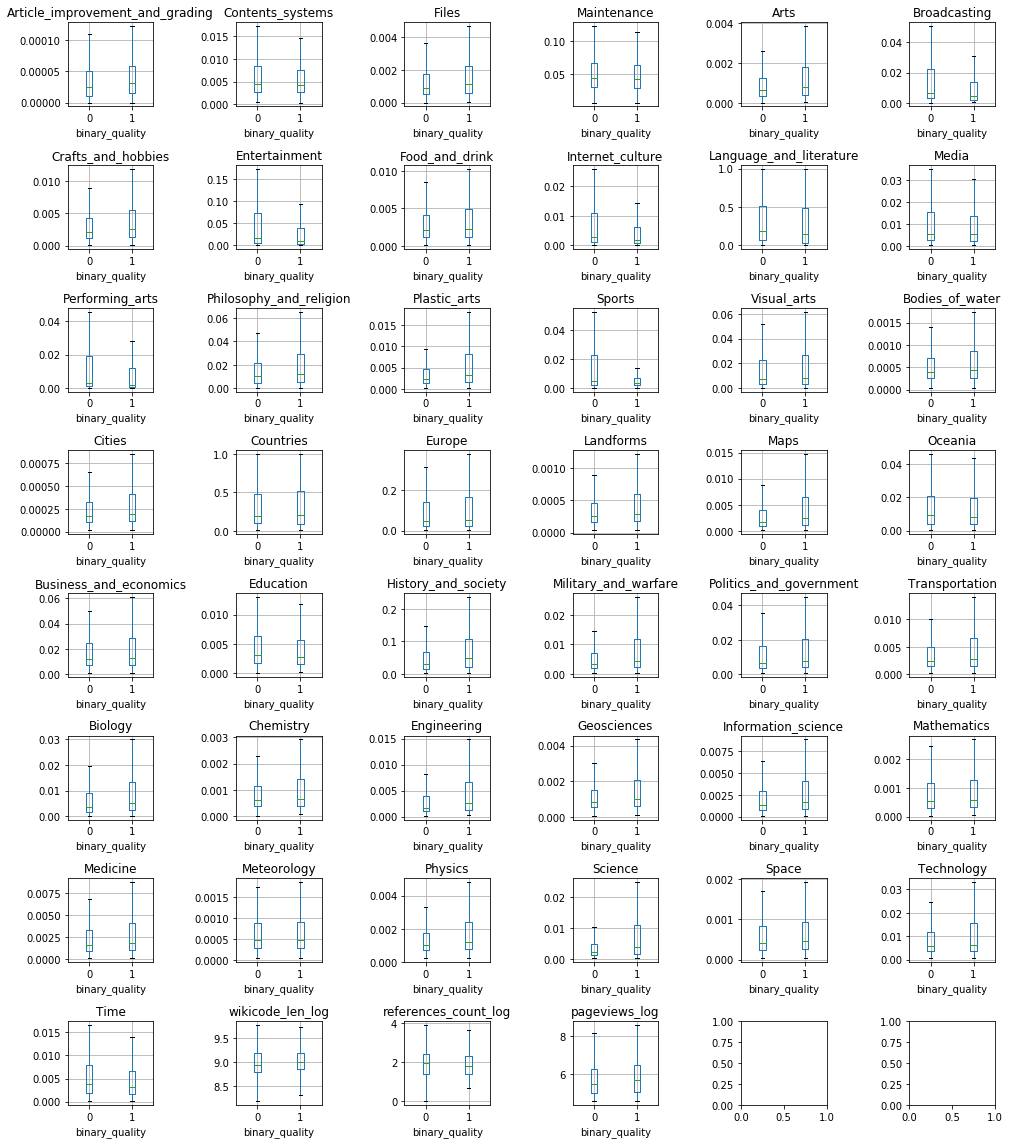

In [18]:
features = ['Assistance-Article_improvement_and_grading',
       'Assistance-Contents_systems', 'Assistance-Files',
       'Assistance-Maintenance', 'Culture-Arts', 'Culture-Broadcasting',
       'Culture-Crafts_and_hobbies', 'Culture-Entertainment',
       'Culture-Food_and_drink', 'Culture-Internet_culture',
       'Culture-Language_and_literature', 'Culture-Media',
       'Culture-Performing_arts', 'Culture-Philosophy_and_religion',
       'Culture-Plastic_arts', 'Culture-Sports', 'Culture-Visual_arts',
       'Geography-Bodies_of_water', 'Geography-Cities', 'Geography-Countries',
       'Geography-Europe', 'Geography-Landforms', 'Geography-Maps',
       'Geography-Oceania', 'History_And_Society-Business_and_economics',
       'History_And_Society-Education',
       'History_And_Society-History_and_society',
       'History_And_Society-Military_and_warfare',
       'History_And_Society-Politics_and_government',
       'History_And_Society-Transportation', 'STEM-Biology', 'STEM-Chemistry',
       'STEM-Engineering', 'STEM-Geosciences', 'STEM-Information_science',
       'STEM-Mathematics', 'STEM-Medicine', 'STEM-Meteorology', 'STEM-Physics',
       'STEM-Science', 'STEM-Space', 'STEM-Technology', 'STEM-Time',
       'wikicode_len_log',
       'references_count_log', 'pageviews_log']

row_count = math.ceil(len(features)/6)

fig, axs = plt.subplots(row_count, 6, figsize=(14,16))

for idx in range(0, len(features)):
    f = features[idx]
    p = matched_features.boxplot(f, by="binary_quality", showfliers=False, ax=axs[idx//6][idx%6])
    plt.subplots_adjust(wspace = .0)
    i=f.find("-")
    if i >= 0:
        axs[idx//6][idx%6].set_title(f[f.index("-")+1:])
    else:
        axs[idx//6][idx%6].set_title(f)
fig.suptitle('')
fig.tight_layout()

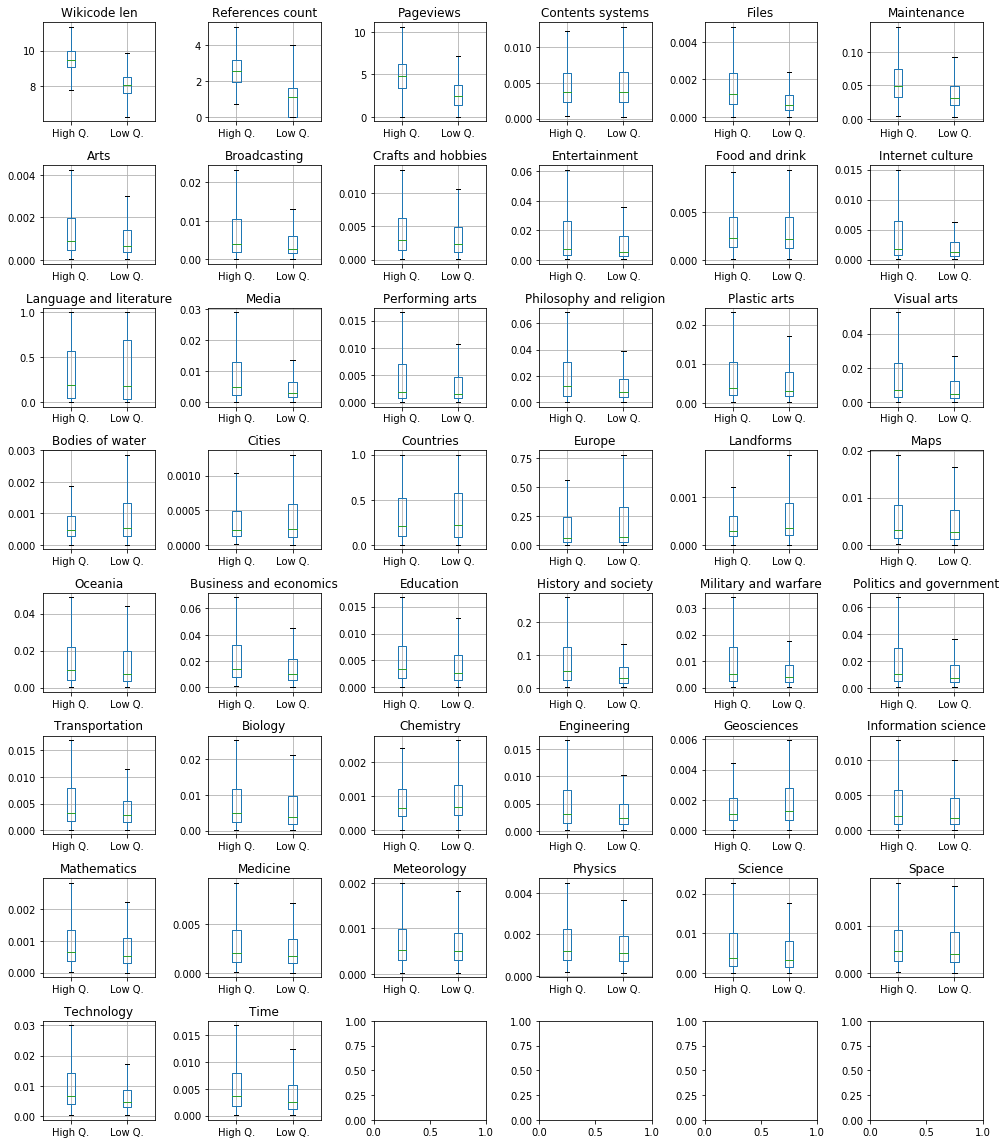

In [50]:
features = [
        'wikicode_len_log',
       'references_count_log', 'pageviews_log',
       'Assistance-Contents_systems', 'Assistance-Files',
       'Assistance-Maintenance', 'Culture-Arts', 'Culture-Broadcasting',
       'Culture-Crafts_and_hobbies', 'Culture-Entertainment',
       'Culture-Food_and_drink', 'Culture-Internet_culture',
       'Culture-Language_and_literature', 'Culture-Media',
       'Culture-Performing_arts', 'Culture-Philosophy_and_religion',
       'Culture-Plastic_arts', 'Culture-Visual_arts',
       'Geography-Bodies_of_water', 'Geography-Cities', 'Geography-Countries',
       'Geography-Europe', 'Geography-Landforms', 'Geography-Maps',
       'Geography-Oceania', 'History_And_Society-Business_and_economics',
       'History_And_Society-Education',
       'History_And_Society-History_and_society',
       'History_And_Society-Military_and_warfare',
       'History_And_Society-Politics_and_government',
       'History_And_Society-Transportation', 'STEM-Biology', 'STEM-Chemistry',
       'STEM-Engineering', 'STEM-Geosciences', 'STEM-Information_science',
       'STEM-Mathematics', 'STEM-Medicine', 'STEM-Meteorology', 'STEM-Physics',
       'STEM-Science', 'STEM-Space', 'STEM-Technology', 'STEM-Time'
       ]

expanded_features['bq'] = expanded_features['binary_quality'].apply(lambda r: "High Q." if r==1 else "Low Q.")

row_count = math.ceil(len(features)/6)

fig, axs = plt.subplots(row_count, 6, figsize=(14,16))

for idx in range(0, len(features)):
    f = features[idx]
    p = expanded_features.boxplot(f, by="bq", showfliers=False, ax=axs[idx//6][idx%6])
    plt.subplots_adjust(wspace = .0)
    p.set_xlabel("")
    i=f.find("-")
    title = f
    if i >= 0:
        title = f[f.index("-")+1:]
    title = title.replace("_", " ")
    title = title[0].upper()+title[1:]
    title = title.replace(" log", "")
    axs[idx//6][idx%6].set_title(title)
fig.suptitle('')
fig.tight_layout()
plt.savefig("features_beforematching_quality.pdf")

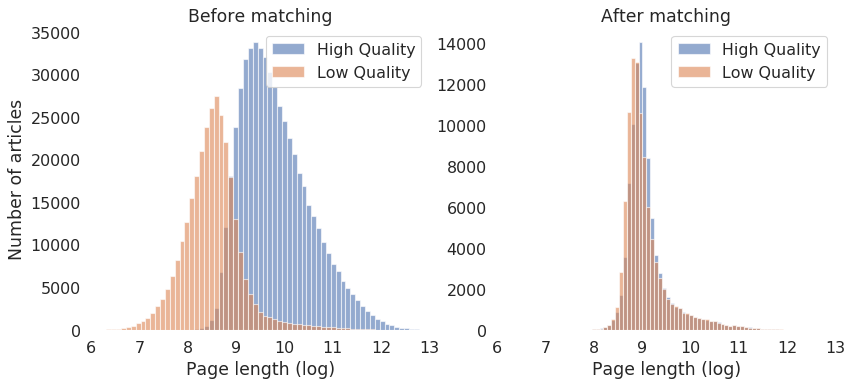

In [15]:
from matplotlib import pyplot
import numpy
import math
from matplotlib.pyplot import figure

sns.set_context("paper")
sns.set(font_scale = 1.3)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})


figure(num=None, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')


plt.subplot(121)

bins = numpy.linspace(5, 15, 100)

limited=expanded_features[(expanded_features.pageviews>=100)].copy()
pyplot.hist(limited[limited.binary_quality==1].wikicode_len_log, bins, alpha=0.6, label='High Quality')
pyplot.hist(limited[limited.binary_quality==0].wikicode_len_log, bins, alpha=0.6, label='Low Quality')
pyplot.legend(loc='upper right')
pyplot.xlabel("Page length (log)")
pyplot.ylabel("Number of articles")
plt.xlim((6, 13))
plt.title("Before matching")

for spine in plt.gca().spines.values():
    spine.set_visible(False)


plt.subplot(122)

bins = numpy.linspace(4, 12, 100)

pyplot.hist(matched_features[matched_features.binary_quality==1].wikicode_len_log, bins, alpha=0.6, label='High Quality')
pyplot.hist(matched_features[matched_features.binary_quality==0].wikicode_len_log, bins, alpha=0.6, label='Low Quality')

pyplot.legend(loc='upper right')
pyplot.xlabel("Page length (log)")
pyplot.ylabel("")
plt.title("After matching")

plt.xlim((6, 13))
for spine in plt.gca().spines.values():
    spine.set_visible(False)

plt.savefig("length_before_after_matching.pdf")

pyplot.show()

In [ ]:
# exit()

In [4]:
from scipy.stats import binned_statistic
import numpy as np
import builtins
import math

def get_stats(bin_samples, stat_type="mean"):
    if len(bin_samples)<1:
        return 
    means_list = []
    for i in range(0, 100):
        samples = np.random.choice(bin_samples, size=len(bin_samples))
        means_list.append(np.mean(samples))
    means_list = sorted(means_list)
    if stat_type=="mean":
        return means_list[len(means_list)//2]
    elif stat_type=="left":
        left_index = int(0.05*len(means_list))
        return means_list[left_index]
    elif stat_type=="right":
        right_index = builtins.min(len(means_list)-1, math.ceil(0.95*len(means_list)))
        return means_list[right_index]

def get_binned_stats(x, y, bins):
    binned = binned_statistic(x, y, 
                     bins=bins, 
                     statistic=lambda r: get_stats(r, "mean"))
    binned_low = binned_statistic(x, y, 
                     bins=bins, 
                     statistic=lambda r: get_stats(r, "left"))
    binned_up = binned_statistic(x, y,
                     bins=bins, 
                     statistic=lambda r: get_stats(r, "right"))
    bins_count = binned_statistic(x, y,
                     bins=bins, 
                     statistic="count")
    return pd.Series(binned.bin_edges).rolling(2, 2).mean().dropna(),\
            binned.statistic, binned_low.statistic, binned_up.statistic, bins_count.statistic


<Figure size 360x216 with 0 Axes>

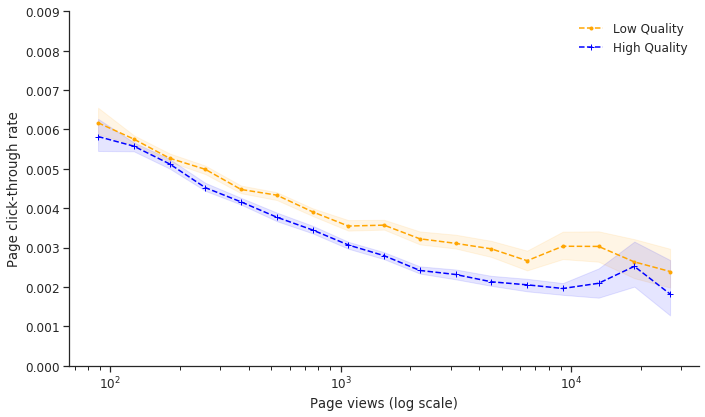

In [5]:
plt.figure(figsize=(5, 3), frameon=False)

fig, ax = plt.subplots(1, 1, figsize=(10,6))

sns.set_context("paper")
sns.set(font_scale = 1.1)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})


ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#######################################
import numpy as np
import math

bins = np.logspace(0, 4.5, 30, base=10)

lq=matched_features[matched_features.binary_quality==0]
hq=matched_features[matched_features.binary_quality==1]


bin_x, mean_values, lower, upper, count = get_binned_stats(
                        lq.pageviews_log.apply(lambda r: math.exp(r)), 
                        lq.page_ct, bins)


ax.plot(bin_x, mean_values, linestyle='--', marker=".", color="orange", label="Low Quality")

ax.fill_between(bin_x, lower,upper, color = 'orange',alpha = 0.1)
plt.gca().set_xscale("log", nonposx='clip')

bin_x, mean_values, lower, upper, count = get_binned_stats(
                        hq.pageviews_log.apply(lambda r: math.exp(r)), 
                        hq.page_ct, bins)

ax.plot(bin_x, mean_values, linestyle='--', marker="+", color="blue", label="High Quality")
ax.fill_between(bin_x, lower,upper, color = 'blue',alpha = 0.1)
plt.gca().set_xscale("log", nonposx='clip')
ax.legend()

ax.set_ylim([0,0.009])

plt.xlabel("Page views (log scale)")
plt.ylabel('Page click-through rate')
###########
leg = plt.legend()
leg.get_frame().set_linewidth(0.0)
plt.tight_layout()


# Statistical test

In [5]:
positive = matched_features[matched_features.binary_quality==1]
negative = matched_features[matched_features.binary_quality==0]

In [6]:
from scipy.stats import mannwhitneyu

# compare distributions
stat, p = mannwhitneyu(positive.page_ct, 
                       negative.page_ct,
                       alternative="two-sided")
alpha = 0.001
if p < alpha:
    print('Statistics=%.3f, p < %.3f' % (stat, alpha))
else:
    print('Statistics=%.3f, p = %.3f' % (stat, p))
# interpret
if p > alpha:
    print('Same distribution (fail to reject H0)')
else:
    print('Different distribution (reject H0)')

Statistics=4850021551.000, p < 0.001
Different distribution (reject H0)


In [7]:
positive.page_ct.mean()

0.004282910481480003

In [8]:
negative.page_ct.mean()

0.0047991196585312765